# Time series analysis from Kaggle Notebook
https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python

In [2]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta # working with dates with style
import hvplot as hv
import hvplot.pandas
from itertools import product                    # some useful functions
import matplotlib.pyplot as plt                  # plots
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
from pathlib import Path
from pypalettes import load_cmap, add_cmap
import seaborn as sns                            # more plots
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm
import statsmodels.formula.api                     # statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tqdm

# Set plot styles
plt.rcParams["figure.figsize"] = [30, 5]
plt.style.use('grayscale')


# Festlegen der Farben
cmap = load_cmap("Apricot")
cmap_continuous = add_cmap(
    colors=["#FFFFFFFF", "#FFF9A1FF", "#BAD09DFF", "#76D3CFFF", "#459E9EFF", "#306677FF", "#24385FFF", "#132157FF"],
    name="apricot_continuous",
    cmap_type="continuous"
)
cmap8 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#005F73FF', '#9093A2FF', '#132157FF'],
    name="apricot8colors",
    cmap_type="discrete"
)
cmap7 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#9093A2FF', '#132157FF'],
    name="apricot7colors",
    cmap_type="discrete"
)


%matplotlib inline



In [3]:
# Load Timestamp of Dataset
df_daily = pd.read_csv('df_daily.csv')
df_hourly = pd.read_csv('df_hourly_2020.csv')
df_daily_test = pd.read_csv('df_daily_2024.csv')
df_hourly_test = pd.read_csv('df_hourly_2024.csv')


## Time series analysis in Python
Analyse aus: https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook 25.07.24, 10:56
Und aus Atwan.2022: *Time Series Analysis*. 10 Building Univariate Time Series Models Using Statistical Methods: https://learning.oreilly.com/library/view/time-series-analysis/9781805124283/text/ch011.xhtml#join-our-book-community-on-discord-9

### Hilfsfunkktionen: check_stationarity, get_top_models_df, plot_forecast, combinator

In [8]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

def get_top_models_df(scores, criterion='AIC', top_n=5):
    sorted_scores = sorted(scores.items(),
                           key=lambda item: item[1][criterion])
   
    top_models = sorted_scores[:top_n]
    data = [v for k, v in top_models]
    df = pd.DataFrame(data)
   
    df['model_id'] = [k for k, v in top_models]
    df.set_index('model_id', inplace=True)
    return df

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

def combinator(items):
    combo = [i for i in product(*items)]
    return combo

# Calls per Hour Using Prophet for Forecasting
https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet?scriptVersionId=26595661

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

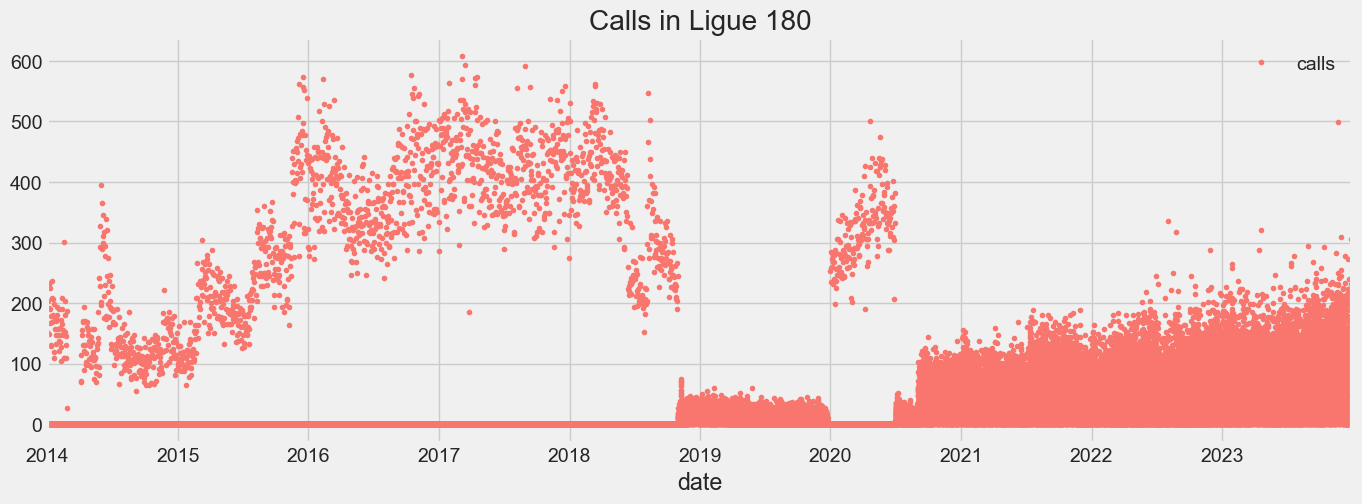

In [ ]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df_hourly.plot(style='.', figsize=(15,5), color=color_pal[0], title='Calls in Ligue 180')
plt.show()

In [ ]:
df_hourly

,calls
date,
2014-01-01 00:00:00,153
2014-01-01 01:00:00,0
2014-01-01 02:00:00,0
2014-01-01 03:00:00,0
2014-01-01 04:00:00,0
...,...
2023-12-31 19:00:00,98
2023-12-31 20:00:00,84
2023-12-31 21:00:00,68


## EDA

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
#    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_hourly, label="calls")

features_and_target = pd.concat([X, y], axis=1)

In [ ]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,calls
date,,,,,,,,
2014-01-01 00:00:00,0,2,1,1,2014,1,1,153
2014-01-01 01:00:00,1,2,1,1,2014,1,1,0
2014-01-01 02:00:00,2,2,1,1,2014,1,1,0
2014-01-01 03:00:00,3,2,1,1,2014,1,1,0
2014-01-01 04:00:00,4,2,1,1,2014,1,1,0


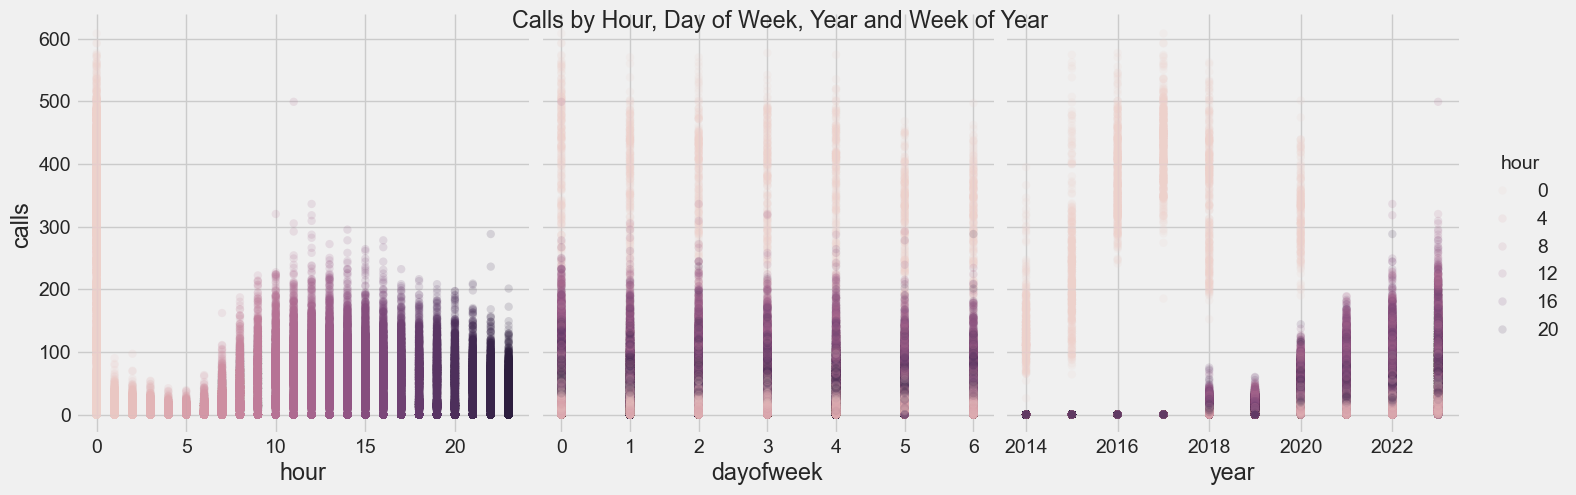

In [ ]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year'],
             y_vars='calls',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Calls by Hour, Day of Week, Year and Week of Year')
plt.show()

In [ ]:
split_date = '01-Jul-2023'
df_hourly_train = df_hourly.loc[df_hourly.index <= split_date].copy()
df_hourly_test = df_hourly.loc[df_hourly.index > split_date].copy()

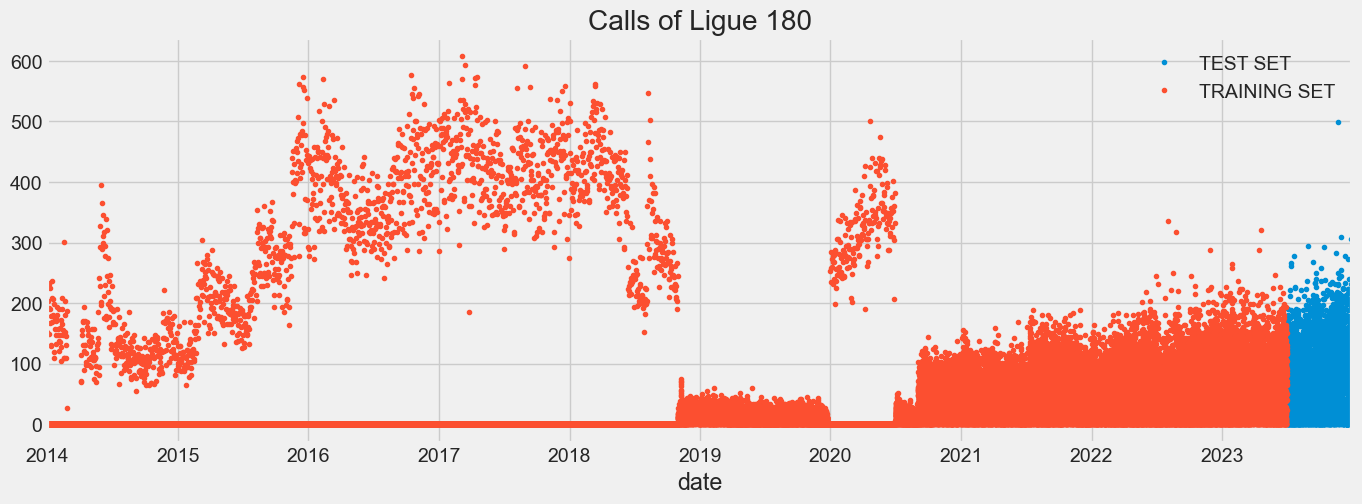

In [ ]:
# Plot train and test so you can see where we have split
df_hourly_test \
    .rename(columns={'calls': 'TEST SET'}) \
    .join(df_hourly_train.rename(columns={'calls': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Calls of Ligue 180', style='.')
plt.show()



In [ ]:
# Format data for prophet model using ds and y
df_hourly_train.reset_index() \
    .rename(columns={'date':'ds',
                     'calls':'y'}).head()

,ds,y
0,2014-01-01 00:00:00,153
1,2014-01-01 01:00:00,0
2,2014-01-01 02:00:00,0
3,2014-01-01 03:00:00,0
4,2014-01-01 04:00:00,0


In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(df_hourly_train.reset_index() \
              .rename(columns={'date':'ds',
                               'calls':'y'}))

11:01:55 - cmdstanpy - INFO - Chain [1] start processing
11:02:30 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Predict on training set with model
df_hourly_test_fcst = model.predict(df=df_hourly_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

In [ ]:
df_hourly_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-07-01 01:00:00,64.995715,28.859927,162.342076,64.995715,64.995715,28.679409,28.679409,28.679409,31.915979,...,-0.970400,-0.970400,-0.970400,-2.266170,-2.266170,-2.266170,0.0,0.0,0.0,93.675124
1,2023-07-01 02:00:00,64.996547,-5.865292,128.192138,64.996547,64.996547,-4.735909,-4.735909,-4.735909,-1.410058,...,-1.053069,-1.053069,-1.053069,-2.272782,-2.272782,-2.272782,0.0,0.0,0.0,60.260638
2,2023-07-01 03:00:00,64.997379,-30.241345,97.640931,64.997379,64.997379,-33.161889,-33.161889,-33.161889,-29.737337,...,-1.145159,-1.145159,-1.145159,-2.279393,-2.279393,-2.279393,0.0,0.0,0.0,31.835489
3,2023-07-01 04:00:00,64.998210,-36.784736,85.180417,64.998210,64.998210,-41.528021,-41.528021,-41.528021,-37.995890,...,-1.246127,-1.246127,-1.246127,-2.286003,-2.286003,-2.286003,0.0,0.0,0.0,23.470189
4,2023-07-01 05:00:00,64.999042,-33.208819,97.048316,64.999042,64.999042,-31.645279,-31.645279,-31.645279,-27.997391,...,-1.355276,-1.355276,-1.355276,-2.292612,-2.292612,-2.292612,0.0,0.0,0.0,33.353763


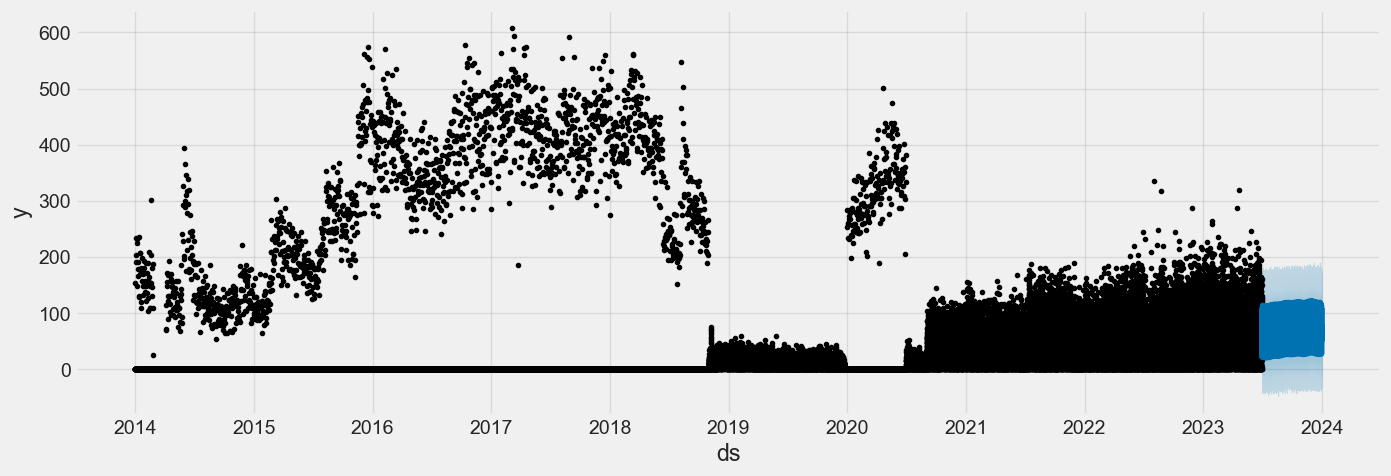

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_hourly_test_fcst,
                 ax=ax)
plt.show()

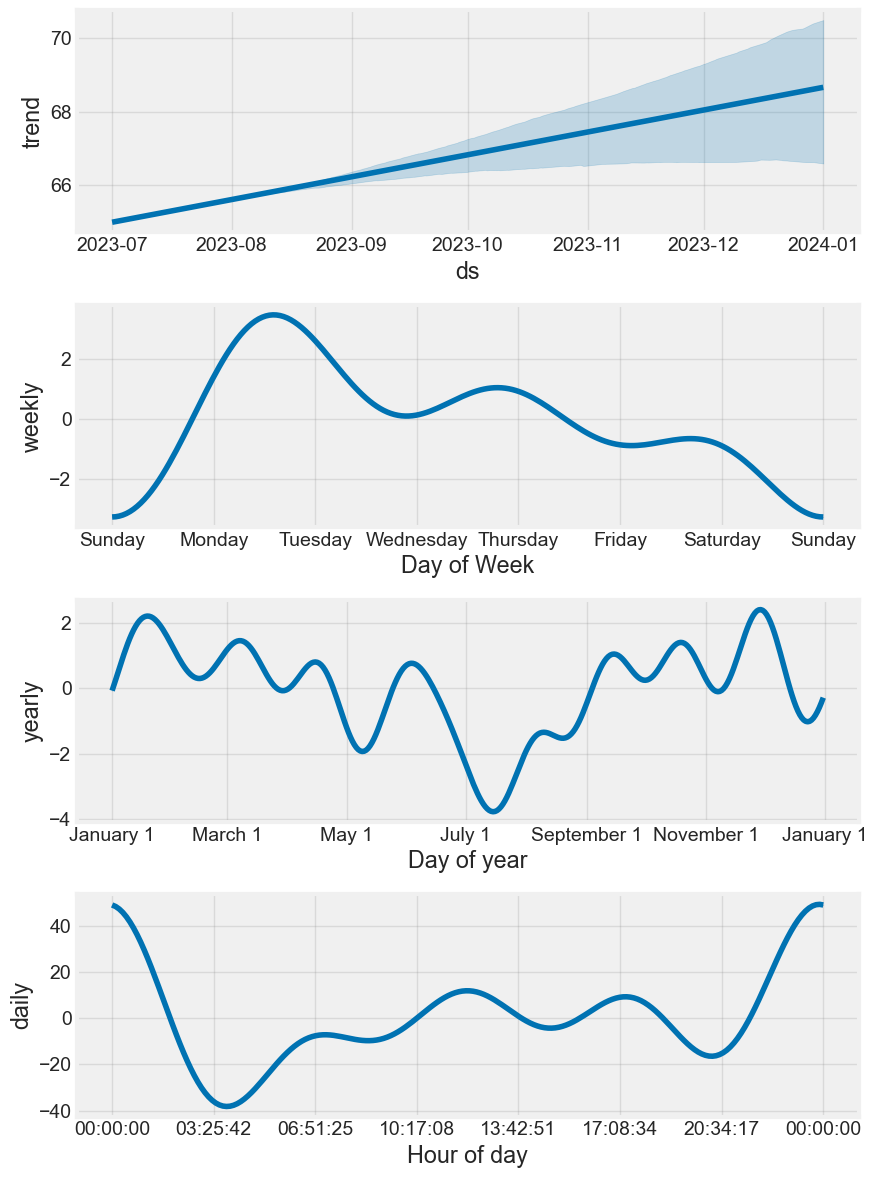

In [ ]:
# Plot the components of the model
fig = model.plot_components(df_hourly_test_fcst)

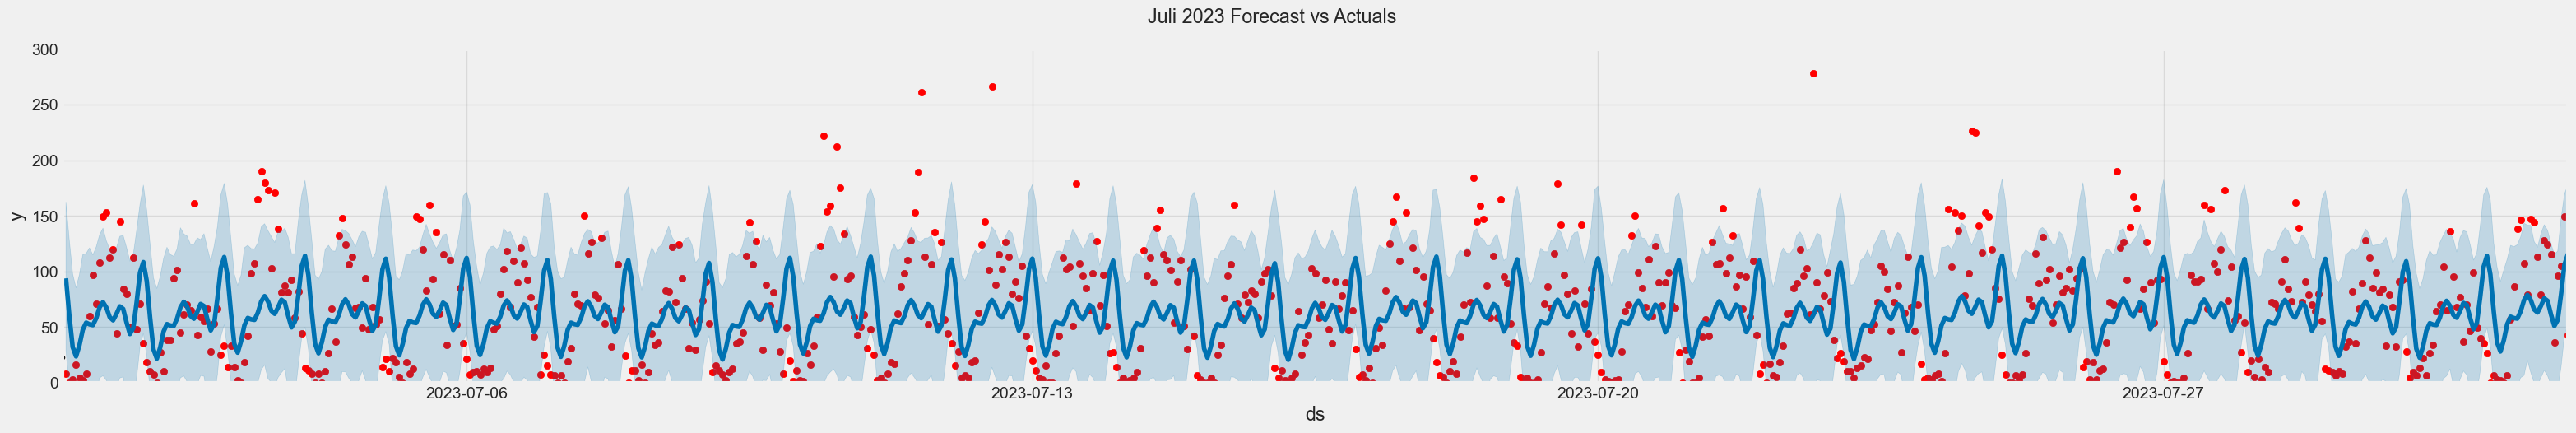

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(35)
ax.scatter(df_hourly_test.index, df_hourly_test['calls'], color='r')
fig = model.plot(df_hourly_test_fcst, ax=ax)
ax.set_xbound(lower=pd.Timestamp('07-01-2023'),
              upper=pd.Timestamp('08-01-2023'))
ax.set_ylim(0, 300)
plot = plt.suptitle('Juli 2023 Forecast vs Actuals')

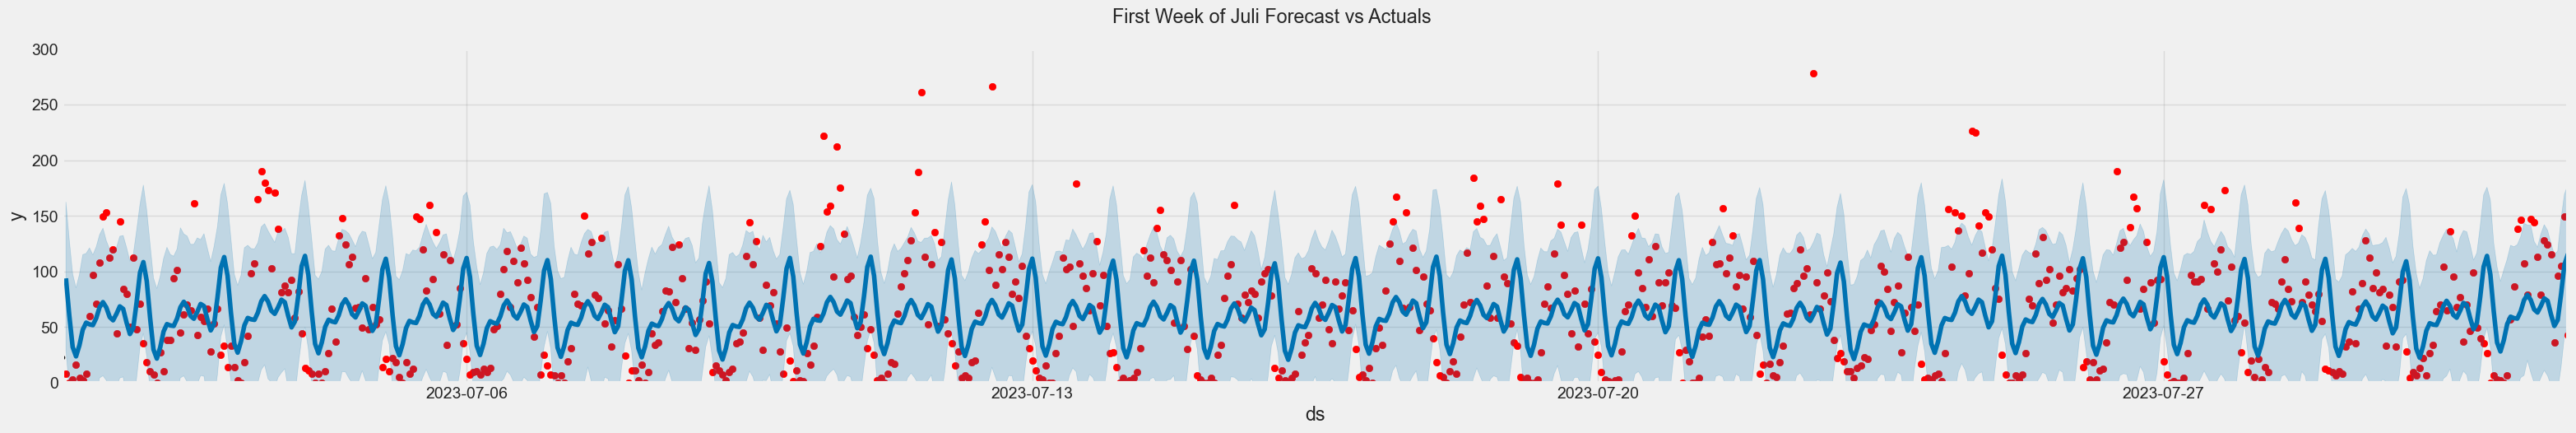

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(35)
ax.scatter(df_hourly_test.index, df_hourly_test['calls'], color='r')
fig = model.plot(df_hourly_test_fcst, ax=ax)
ax.set_xbound(lower=pd.Timestamp('07-01-2023'),
              upper=pd.Timestamp('08-01-2023'))
ax.set_ylim(0, 300)
plot = plt.suptitle('First Week of Juli Forecast vs Actuals')